# reference
- https://github.com/HabanaAI/Model-References/tree/master/TensorFlow/computer_vision/SSD_ResNet34
- https://yeomko.tistory.com/20
- https://github.com/experiencor/keras-yolo2
- step by step yolo3  https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb
- pytorch yolo3 : https://deep-learning-study.tistory.com/422
- tf yolo1: https://velog.io/@minkyu4506/YOLO-v1-리뷰-코드-구현tensorflow2

- yolo4 on keras : https://github.com/hunglc007/tensorflow-yolov4-tflite


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -rf ./dataset
!unzip /content/drive/MyDrive/colab/didimdol/dataset/train_zoom_left_clock2.zip -d ./dataset/ > /dev/null

In [3]:
!ln -s /content/drive/MyDrive/colab/didimdol /content/

In [4]:
!mkdir ./dataset/server_room_aug
!mv ./dataset/train_zoom_left_clock ./dataset/server_room_aug

In [5]:
from didimdol.model.tensorflow.yolo.yolo import YOLO, decode, compute_loss, decode_train
from didimdol.model.tensorflow.yolo.dataset import Dataset
import tensorflow as tf

import pandas as pd
import numpy as np
import time
from tqdm import tqdm

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cv2

plt.rcParams["figure.figsize"] = (20,10)

import logging
import os


In [6]:
INPUT_SIZE = 416
NUM_CLASS = 10
EPOCHS = 100
BATCH_SIZE = 64
IOU_LOSS_THRESH = 0.5

CLASSES = ['0','1','2','3','4','5','6','7','8','9']
ANCHORS        = [23,27, 37,58, 81,82, 81,82, 135,169, 344,319]

# STRIDES       =  [8, 16, 32]
STRIDES       =  [16, 32]

XYSCALE       = [1.05, 1.05]

ANCHOR_PER_SCALE     = 3

In [7]:
palette = [(255, 56, 56),
    (255, 157, 151),
    (255, 112, 31),
    (255, 178, 29),
    (207, 210, 49),
    (72, 249, 10),
    (146, 204, 23),
    (61, 219, 134),
    (26, 147, 52),
    (0, 212, 187),
    (44, 153, 168),
    (0, 194, 255),
    (52, 69, 147),
    (100, 115, 255),
    (0, 24, 236),
    (132, 56, 255),
    (82, 0, 133),
    (203, 56, 255),
    (255, 149, 200),
    (255, 55, 199)]

# 모델 구조 생성

In [ ]:
input_layer = tf.keras.layers.Input([INPUT_SIZE, INPUT_SIZE, 3])

feature_maps = YOLO(input_layer, NUM_CLASS, is_tiny = True)
bbox_tensors = []
for i, fm in enumerate(feature_maps):
    if i == 0:
        bbox_tensor = decode_train(fm, INPUT_SIZE // 16, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    elif i == 1:
        bbox_tensor = decode_train(fm, INPUT_SIZE // 32, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    # else:
    #     bbox_tensor = decode_train(fm, INPUT_SIZE // 32, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
        
    bbox_tensors.append(fm)
    bbox_tensors.append(bbox_tensor)

model = tf.keras.Model(input_layer, bbox_tensors)

In [11]:
#model.load_weights( './didimdol/checkpoints/yolov4') # "./didimdol/checkpoints/yolov4")
model = tf.keras.models.load_model('./didimdol/checkpoints/yolov4/400_best', compile = False)
# model = infer_model

# 학습 데이터 로드

In [ ]:
annot_path = 'dataset/train_digit_zoom_left_clock_2.txt'
trainset = Dataset(annot_path, INPUT_SIZE, BATCH_SIZE,  CLASSES, ANCHORS, ANCHOR_PER_SCALE, STRIDES, data_aug=True, is_training=True)
len(trainset)

11

# 학습 시작

In [ ]:
training_name = 'yolov4_leftclock'
logger = logging.getLogger('train_log')
logger.setLevel(logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
start_time = time.time()
model_save_path = "didimdol/log/{}/{:.0f}/".format(training_name, start_time)

if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
logger.handlers.clear()
logging_path = "{}train.log".format(model_save_path)
fh = logging.FileHandler(filename=logging_path)
fh.setLevel(logging.INFO)
# logger.addHandler(ch)
logger.addHandler(fh)

logger.info('logging file path : {}'.format(logging_path))

INFO:train_log:logging file path : didimdol/log/yolov4_leftclock/1661428044/train.log


In [ ]:
EPOCHS = 500
progress = tqdm(range(EPOCHS))
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
total_steps = len(trainset) * EPOCHS

elapsed = 0.
pre_total_loss= tf.constant(0.)

START_LR = 1e-3
END_LR = 1e-6
optimizer = tf.keras.optimizers.Adam(learning_rate=START_LR)

for epoch in progress:

    total_giou_loss = 0.
    total_conf_loss = 0.
    total_prob_loss = 0.
    total_loss = 0.

    start_time = time.time()

    # progress = tqdm(trainset)
    for image_data, target in trainset:
        with tf.GradientTape() as tape:
            pred_result = model(image_data, training=True)
            giou_loss = conf_loss = prob_loss = 0
            
            # optimizing process
            for i in range(2):
                conv, pred = pred_result[i * 2], pred_result[i * 2 + 1]
                loss_items = compute_loss(pred, conv, target[i][0], target[i][1], STRIDES=STRIDES, NUM_CLASS=NUM_CLASS, IOU_LOSS_THRESH=IOU_LOSS_THRESH, i=i)
                giou_loss += loss_items[0]
                conf_loss += loss_items[1]
                prob_loss += loss_items[2]

            step_loss = giou_loss + conf_loss + prob_loss

            gradients = tape.gradient(step_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            global_steps.assign_add(1)
            lr = END_LR + 0.5 * (START_LR - END_LR) * (
                    (1 + tf.cos((global_steps) / (total_steps) * np.pi))
                )
            optimizer.lr.assign(lr.numpy())

            total_loss += step_loss

            total_giou_loss += giou_loss
            total_conf_loss += conf_loss
            total_prob_loss += prob_loss

            progress.set_postfix({'pre_elapsed': elapsed, 'pre_total_loss': pre_total_loss.numpy(), 'cur step loss' : step_loss.numpy(), 'lr': lr.numpy()})
        
    pre_total_loss = total_loss / len(trainset)
    total_conf_loss = total_conf_loss / len(trainset)
    total_giou_loss = total_giou_loss / len(trainset)
    total_prob_loss = total_prob_loss / len(trainset)

    elapsed = time.time()- start_time


    if(epoch % 100) == 0 and epoch > 0:
        log = 'trn {:d}: elapsed {:.2f}s, iou loss {:.4f}, conf loss {:.4f}, prob loss {:.4f}, total loss {:.4f}, lr {:.6f}'.format(
                epoch, 
                elapsed, 
                total_giou_loss.numpy(), 
                total_conf_loss.numpy(), 
                total_prob_loss.numpy(), 
                pre_total_loss.numpy(),
                lr.numpy())
        logger.info(log)
        model.save("./didimdol/checkpoints/yolov4/{}".format(epoch))

    # print(log)


model.save("./didimdol/checkpoints/yolov4/{}".format(epoch))

100%|██████████| 500/500 [4:29:38<00:00, 32.36s/it, pre_elapsed=32.5, pre_total_loss=2.41, cur step loss=2.16, lr=1e-6]


In [12]:
def infer(model, image_path, IOU_THRESHOLD = 0.4, INPUT_SIZE= 416):
    o_image = cv2.imread(image_path)
    o_image = cv2.cvtColor(o_image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(o_image, (INPUT_SIZE, INPUT_SIZE))
    image = image / 255.
    

    images_data = []
    pred_bbox = []
    for i in range(1):
        images_data.append(image)
    images_data = np.asarray(images_data).astype(np.float32)
    batch_data = tf.constant(images_data)
    
    preds = model(batch_data, training=False)

    box_list = []
    conf_list = []
    for idx, output in enumerate(preds):
        if idx % 2 == 0 : continue
        boxes = output[:, :, :, :,  0:4]
        pred_conf = output[:, :, :, :, 4:]

        bs, xi, yi, anc, xywh = boxes.shape
        box_list.append(tf.reshape(boxes, (bs, -1, 1, xywh)))
        bs, xi, yi, anc, conf = pred_conf.shape
        conf_list.append(tf.reshape(pred_conf, (bs, -1, conf)))

    boxes = tf.concat([box_list[0], box_list[1]], 1).numpy()
    pred_conf =  tf.concat([conf_list[0], conf_list[1]], 1).numpy()

    classes_prob =  pred_conf[:, :, 1:] * pred_conf[:, :, :1]

    boxes[:,:,:,0] = boxes[:,:,:,0] - (boxes[:,:,:, 2] / 2) # x1
    boxes[:,:,:,1] = boxes[:,:,:,1] - (boxes[:,:,:, 3] / 2) # y1

    boxes[:,:,:,2] = boxes[:,:,:,0] + boxes[:,:,:, 2] # x2
    boxes[:,:,:,3] = boxes[:,:,:,1] + boxes[:,:,:, 3] # y2

    o_boxes, scores, classes, detections = tf.image.combined_non_max_suppression(
        boxes=boxes,
        scores=classes_prob,
        max_output_size_per_class= 20,
        max_total_size=30,
        iou_threshold=IOU_THRESHOLD,
        score_threshold=0.25,
        clip_boxes = False
    )

    return o_image, o_boxes, scores, classes, detections

def bbox_iou(box1, box2):
    w = max(min(box1[2], box2[2]) - max(box1[0], box2[0]), 0)
    h = max(min(box1[3], box2[3]) - max(box1[1], box2[1]), 0)

    g = ((box1[2] - box1[0]) * (box1[3] - box1[1])) + ((box2[2] - box2[0]) * (box2[3] - box2[1]))
  
    iou = (w * h)/g if (w * h) != 0 else 0.

    return iou

In [23]:
INPUT_SIZE = 416
NUM_CLASS = 10
EPOCHS = 100
BATCH_SIZE = 64
IOU_LOSS_THRESH = 0.3

CLASSES = ['0','1','2','3','4','5','6','7','8','9']
ANCHORS        = [23,27, 37,58, 81,82, 81,82, 135,169, 344,319]

# STRIDES       =  [8, 16, 32]
STRIDES       =  [16, 32]
XYSCALE       = [1.05, 1.05]
ANCHOR_PER_SCALE     = 3

palette = [(255, 56, 56),
    (255, 157, 151),
    (255, 112, 31),
    (255, 178, 29),
    (207, 210, 49),
    (72, 249, 10),
    (146, 204, 23),
    (61, 219, 134),
    (26, 147, 52),
    (0, 212, 187),
    (44, 153, 168),
    (0, 194, 255),
    (52, 69, 147),
    (100, 115, 255),
    (0, 24, 236),
    (132, 56, 255),
    (82, 0, 133),
    (203, 56, 255),
    (255, 149, 200),
    (255, 55, 199)]

In [25]:
with open('/content/dataset/train_digit_zoom_left_clock_2.txt', 'r') as anno:
    lines = anno.readlines()

    preds = []
    trues = []

    for row in tqdm(lines):
        col = row.split()
        img_path = col[0]

        img, o_boxes, scores, classes, detections = infer(model, img_path, IOU_THRESHOLD=IOU_LOSS_THRESH) 

        num_objects = len(col[1:])

        collect_count = 0

        pred_label = np.zeros(shape=[num_objects], dtype=np.int16)
        # pred_label += 10

        img_w, img_h, _ = img.shape
        for i, bbox in enumerate(col[1:]):
            x1, y1, x2, y2, label = bbox.split(',')

            t_box = np.array([x1, y1, x2, y2], dtype = np.float32)
            t_label = int(label)

            trues.append(t_label)

            batch_idx = 0
            cur_iou = IOU_LOSS_THRESH
            for j in range(detections[0].numpy()):
                p_box = o_boxes[batch_idx][j]

                p_box = p_box / INPUT_SIZE
                x1 = int(img_w * p_box[0])
                y1 = int(img_h * p_box[1])
                x2 = int(img_w * p_box[2])
                y2 = int(img_h * p_box[3])

                p_box = [x1,y1,x2,y2]

                iou = bbox_iou(t_box, p_box)
                if iou >= cur_iou:
                    pred_label[i] = int(classes[batch_idx][j])
                    cur_iou = iou
 
        preds += pred_label.tolist()

100%|██████████| 641/641 [02:19<00:00,  4.59it/s]


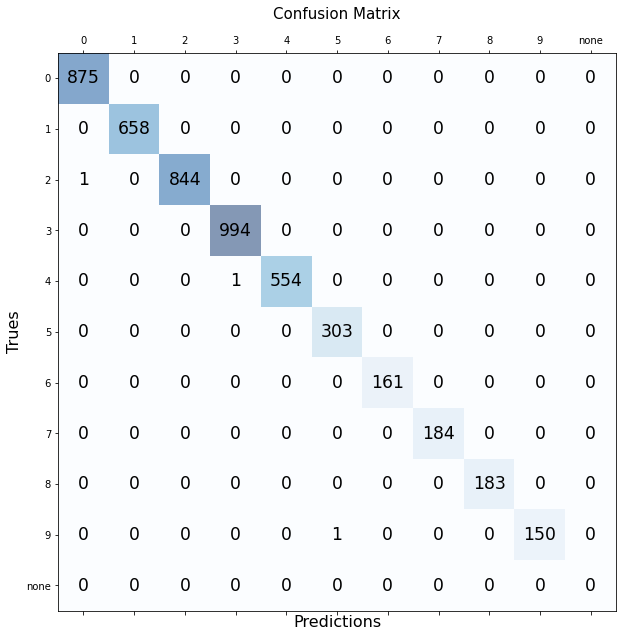

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

mat_con = (confusion_matrix(trues, preds, labels=[0,1,2,3,4,5,6,7,8,9,10]))
plt.matshow(mat_con, cmap=plt.cm.Blues, alpha=0.5)
for m in range(mat_con.shape[0]):
    for n in range(mat_con.shape[1]):
        plt.text(x=n,y=m,s=mat_con[m, n], va='center', ha='center', size='xx-large')

plt.xticks([0,1,2,3,4,5,6,7,8,9,10], labels=['0','1','2','3','4','5','6','7','8','9','none'])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10], labels=['0','1','2','3','4','5','6','7','8','9','none'])
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Trues', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)

plt.show()

5:0.99 tf.Tensor([0.41836417 0.44683844 0.45689422 0.5193245 ], shape=(4,), dtype=float32)
8:0.98 tf.Tensor([0.37489468 0.44682965 0.4111869  0.5193007 ], shape=(4,), dtype=float32)
2:0.98 tf.Tensor([0.54066575 0.43012208 0.57912916 0.48073083], shape=(4,), dtype=float32)
3:0.98 tf.Tensor([0.5791451  0.48088902 0.6102533  0.5314204 ], shape=(4,), dtype=float32)
0:0.98 tf.Tensor([0.57689106 0.4301867  0.60819334 0.48083827], shape=(4,), dtype=float32)
3:0.97 tf.Tensor([0.5455354 0.4786757 0.5791866 0.5338335], shape=(4,), dtype=float32)
0:0.96 tf.Tensor([0.45885435 0.44721475 0.50204474 0.51926386], shape=(4,), dtype=float32)


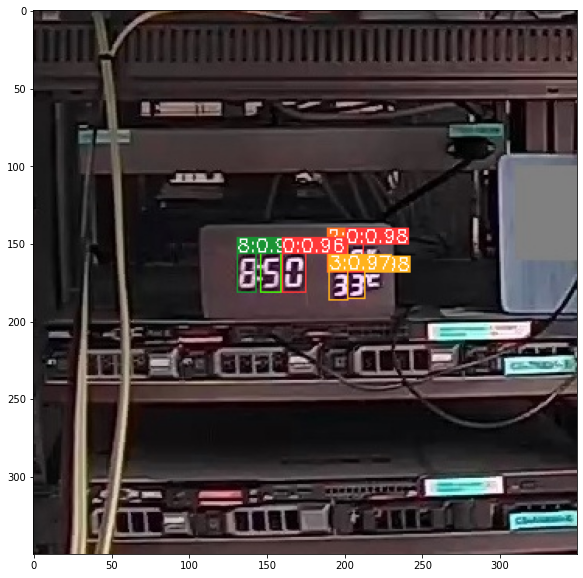

In [27]:
img, o_boxes, scores, classes, detections = infer(model, './dataset/server_room_aug/train_zoom_left_clock/0851_image_4_0_0.jpg')

img_w, img_h, _ = img.shape
for idx, box in enumerate(o_boxes[0][:detections[0]]):
    box = box / INPUT_SIZE
    x1 = int(img_w * box[0])
    y1 = int(img_h * box[1])
    x2 = int(img_w * box[2])
    y2 = int(img_h * box[3])

    class_idx = int(classes[0][idx])
    color = palette[class_idx]
    # score = int(scores[0][idx] * 100)

    cv2.rectangle(img, (x1, y1), (x2,y2), color, 1)
    cv2.rectangle(img, (x1, y1-10), (x1+40,y1), color, -1)
   
    cv2.putText(img, '{}:{:.2f}'.format(class_idx, scores[0][idx]), (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
    print('{}:{:.2f}'.format(class_idx, scores[0][idx]), box)

plt.rcParams["figure.figsize"] = (20,10)

plt.imshow(img)
plt.show()

In [ ]:
def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

In [ ]:
for idx, layer in enumerate(infer_model.layers):
    if layer.name.find('leaky_relu_48') > 0:
        route_1 = layer
        freeze_all(layer)
    elif layer.name.find('leaky_relu_49') > 0:
        conv = layer
        freeze_all(layer)
    # break


route_1, conv

(<keras.layers.core.tf_op_layer.TFOpLambda at 0x16438aeb0>,
 <keras.layers.core.tf_op_layer.TFOpLambda at 0x16439f7c0>)

In [ ]:
import model.tensorflow.yolo.common as common

In [ ]:
def YOLOv4_tiny(route_1, conv, NUM_CLASS):
    # route_1, conv = backbone.cspdarknet53_tiny(input_layer) #  route_1 =  tf.nn.leaky_relu_48, conv = tf.nn.leaky_relu_49

    conv = common.convolutional(conv, (1, 1, 512, 256))

    conv_lobj_branch = common.convolutional(conv, (3, 3, 256, 512))
    conv_lbbox = common.convolutional(conv_lobj_branch, (1, 1, 512, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.upsample(conv)
    conv = tf.concat([conv, route_1], axis=-1)

    conv_mobj_branch = common.convolutional(conv, (3, 3, 128, 256))
    conv_mbbox = common.convolutional(conv_mobj_branch, (1, 1, 256, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    return [conv_mbbox, conv_lbbox]

In [ ]:
m = YOLOv4_tiny(route_1.output, conv.output, NUM_CLASS)

In [ ]:
bbox_tensors = []
for i, fm in enumerate(m):
    if i == 0:
        bbox_tensor = decode_train(fm, INPUT_SIZE // 16, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    elif i == 1:
        bbox_tensor = decode_train(fm, INPUT_SIZE // 32, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    # else:
    #     bbox_tensor = decode_train(fm, INPUT_SIZE // 32, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
        
    bbox_tensors.append(fm)
    bbox_tensors.append(bbox_tensor)

model = tf.keras.Model(infer_model.layers[0].input, bbox_tensors)

In [ ]:
annot_path = 'dataset/server_room_aug/train_digit_2.txt'
trainset = Dataset(annot_path, INPUT_SIZE, BATCH_SIZE,  CLASSES, ANCHORS, ANCHOR_PER_SCALE, STRIDES, data_aug=True, is_training=True)
len(trainset)

shuffle


81

In [ ]:
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
total_steps = len(trainset) * EPOCHS

for epoch in range(EPOCHS):
    total_loss = 0.
    total_giou_loss = 0.
    total_conf_loss = 0.
    total_prob_loss = 0.

    start_time = time.time()

    progress = tqdm(trainset)
    for image_data, target in progress:
        with tf.GradientTape() as tape:
            pred_result = model(image_data, training=True)
            giou_loss = conf_loss = prob_loss = 0
            
            # optimizing process
            for i in range(2):
                conv, pred = pred_result[i * 2], pred_result[i * 2 + 1]
                loss_items = compute_loss(pred, conv, target[i][0], target[i][1], STRIDES=STRIDES, NUM_CLASS=NUM_CLASS, IOU_LOSS_THRESH=IOU_LOSS_THRESH, i=i)
                giou_loss += loss_items[0]
                conf_loss += loss_items[1]
                prob_loss += loss_items[2]

            step_loss = giou_loss + conf_loss + prob_loss

            gradients = tape.gradient(step_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            global_steps.assign_add(1)
            lr = 1e-6 + 0.5 * (1e-3 - 1e-6) * (
                    (1 + tf.cos((global_steps) / (total_steps) * np.pi))
                )
            optimizer.lr.assign(lr.numpy())

            total_loss += step_loss

            total_giou_loss += giou_loss
            total_conf_loss += conf_loss
            total_prob_loss += prob_loss
            
            progress.set_description('epoch {}'.format(epoch+1))
            progress.set_postfix({'loss' : step_loss.numpy()})
    progress.clear()
        
    total_loss = total_loss / len(trainset)
    total_conf_loss = total_conf_loss / len(trainset)
    total_giou_loss = total_giou_loss / len(trainset)
    total_prob_loss = total_prob_loss / len(trainset)

    print('epoch {:d} trn: elapsed {:.2f}s, iou loss {:.4f}, conf loss {:.4f}, prob loss {:.4f}, total loss {:.4f}'.format(
            epoch+1, 
            time.time()- start_time, 
            total_giou_loss.numpy(), 
            total_conf_loss.numpy(), 
            total_prob_loss.numpy(), 
            total_loss.numpy()))


    model.save("./didimdol/checkpoints/yolov4")


In [ ]:
END_LR = 1e-6
START_LR = 1e-3

global_steps = np.array(range(100))
total_steps = 100

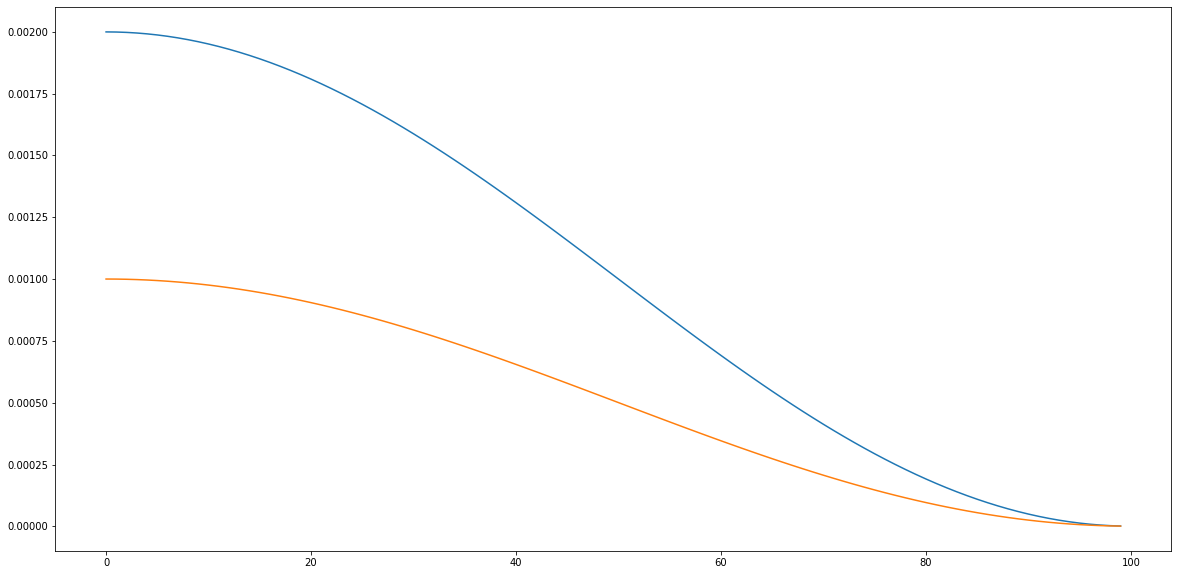

In [ ]:
lr = END_LR + (START_LR - END_LR) * (
                    (1 + np.cos((global_steps) / (total_steps) * np.pi))
                )

lr2 = END_LR + 0.5* (START_LR - END_LR) * (
                    (1 + np.cos((global_steps) / (total_steps) * np.pi))
                )
plt.plot(lr)
plt.plot(lr2)

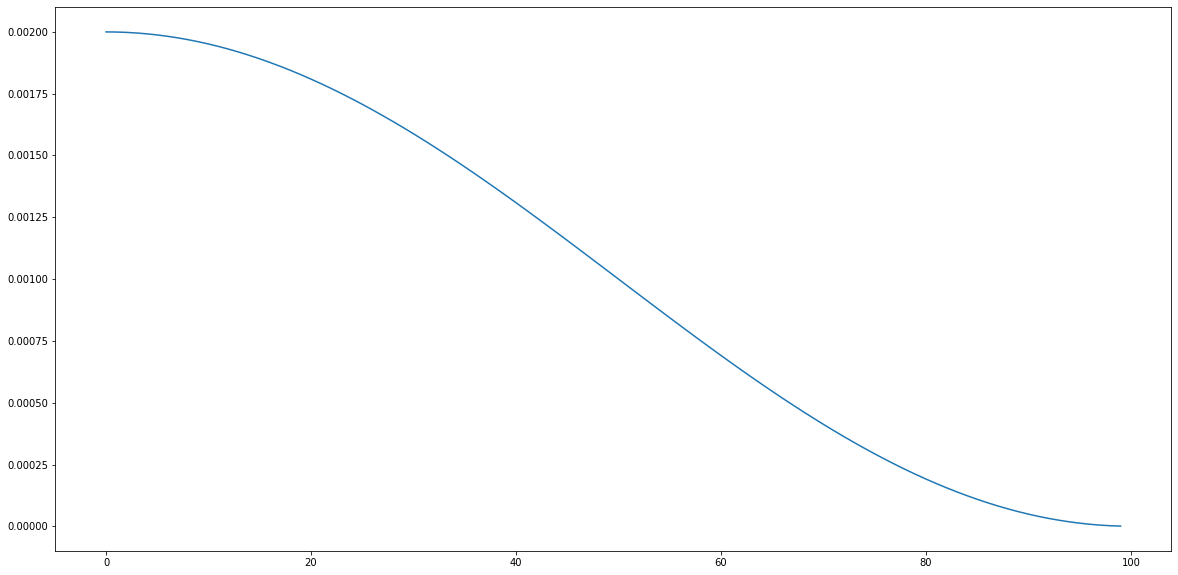

In [ ]:
plt.plot(lr)

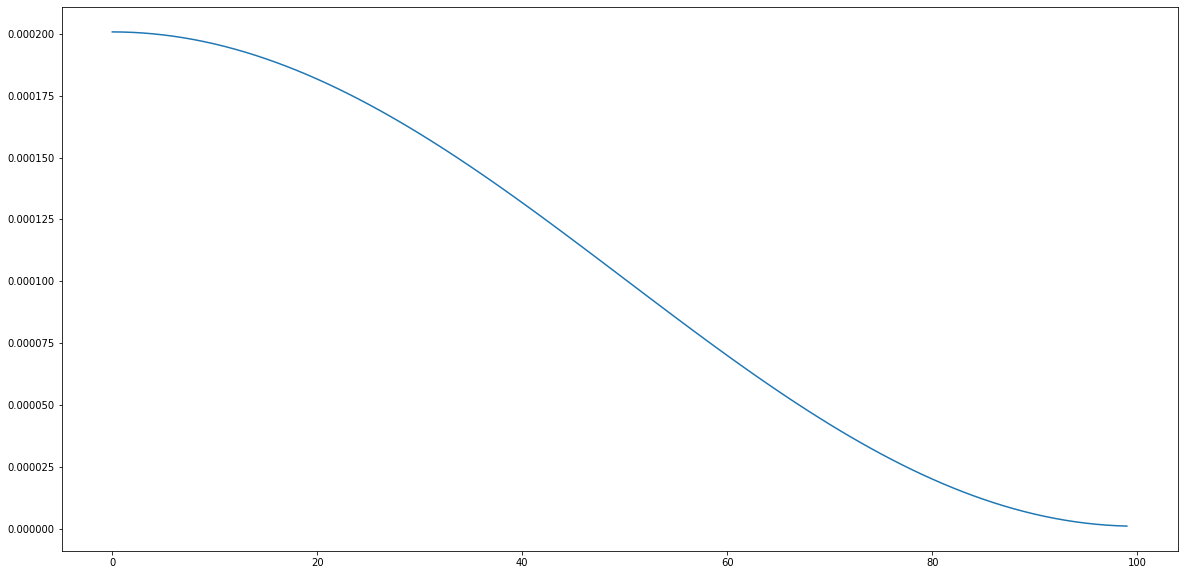

In [ ]:
lr = END_LR + 0.8* (START_LR - END_LR) * (
                    (1 + np.cos((global_steps) / (total_steps) * np.pi))
                )
plt.plot(lr)

In [ ]:
image = cv2.imread('/Users/handh/dev/workspace/python/didimdol_ai_model/dataset/server_room_aug/train/0007_image_4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# image = image[100:400, 100:500]

plt.imshow(image)
plt.show()

image_data = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE))

plt.imshow(image_data)
plt.show()

image_data = image_data / 255.

images_data = []
pred_bbox = []
for i in range(1):
    images_data.append(image_data)
images_data = np.asarray(images_data).astype(np.float32)
batch_data = tf.constant(images_data)
preds = infer_model(batch_data, training=False)

box_list = []
conf_list = []
for idx, output in enumerate(preds):
    if idx % 2 == 0 : continue
    boxes = output[:, :, :, :,  0:4]
    pred_conf = output[:, :, :, :, 4:]

    bs, xi, yi, anc, xywh = boxes.shape
    box_list.append(tf.reshape(boxes, (bs, -1, 1, xywh)))
    bs, xi, yi, anc, conf = pred_conf.shape
    conf_list.append(tf.reshape(pred_conf, (bs, -1, conf)))

boxes = tf.concat([box_list[0], box_list[1]], 1).numpy()
pred_conf =  tf.concat([conf_list[0], conf_list[1]], 1).numpy()

classes_prob =  pred_conf[:, :, 1:] * pred_conf[:, :, :1]

boxes[:,:,:,0] = boxes[:,:,:,0] - (boxes[:,:,:, 2] / 2) # x1
boxes[:,:,:,1] = boxes[:,:,:,1] - (boxes[:,:,:, 3] / 2) # y1

boxes[:,:,:,2] = boxes[:,:,:,0] + boxes[:,:,:, 2] # x2
boxes[:,:,:,3] = boxes[:,:,:,1] + boxes[:,:,:, 3] # y2

o_boxes, scores, classes, detections = tf.image.combined_non_max_suppression(
    boxes=boxes,
    scores=classes_prob,
    max_output_size_per_class= 20,
    max_total_size=30,
    iou_threshold=0.4,
    score_threshold=0.3,
    clip_boxes = False
)

o_h, o_w, _ = image.shape
for idx, box in enumerate(o_boxes[0]):
    box = box / INPUT_SIZE
    x1 = int(o_w * box[0])
    y1 = int(o_h * box[1])
    x2 = int(o_w * box[2])
    y2 = int(o_h * box[3])

    cv2.rectangle(image, (x1, y1), (x2,y2), (255,0,0), 1)
    cv2.rectangle(image, (x1, y1-10), (x1+10,y1), (255,0,0), -1)
    cv2.putText(image, '{}'.format(int(classes[0][idx])), (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
    
plt.imshow(image)
plt.show()
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

image_data = cv2.resize(original_image, (INPUT_SIZE, INPUT_SIZE))
image_data = image_data / 255.

images_data = []
pred_bbox = []
for i in range(1):
    images_data.append(image_data)
images_data = np.asarray(images_data).astype(np.float32)
batch_data = tf.constant(images_data)
preds = infer_model(batch_data, training=False)

box_list = []
conf_list = []
for idx, output in enumerate(preds):
    if idx % 2 == 0 : continue
    boxes = output[:, :, :, :,  0:4]
    pred_conf = output[:, :, :, :, 4:]
    box_list.append(tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)))
    conf_list.append(tf.reshape(pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])))

boxes = tf.concat([box_list[0], box_list[1]], 1)
pred_conf =  tf.concat([conf_list[0], conf_list[1]], 1)

o_h, o_w, _ = original_image.shape

mask = pred_conf[:,:,0] >= 0.25
mask = tf.reshape(mask, mask.shape[1])

for idx, box in enumerate(boxes[0]):
    # if mask[idx]:
    if mask[idx]:
        print(box, pred_conf[0,idx,0], np.argmax(pred_conf[0,idx,1:]))
        box = box[0] / INPUT_SIZE

        w = o_w * box[2]
        h = o_h * box[3]

        x1 = int(o_w * box[0] - (w/2))
        y1 = int(o_h * box[1] - (h/2))
        x2 = int(x1 + w)
        y2 = int(y1 + h)

        # print(box, x1, y1, x2, y2)
        cv2.rectangle(original_image, (x1, y1), (x2,y2), (255,0,0), 1)

plt.imshow(original_image)
plt.show()

error: ignored

In [ ]:
!rm -rf ./didimdol/eval
!mkdir ./didimdol/eval

In [ ]:
import glob
import os 
from tqdm import tqdm


OUTPUT_DIR = './didimdol/eval'

def inference(model, image_dir, output_dir = OUTPUT_DIR):
    paths = glob.glob(image_dir, recursive=True)
    for img_path in tqdm(paths):
        original_image = cv2.imread(img_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        o_h, o_w, _ = original_image.shape

        image_data = cv2.resize(original_image, (INPUT_SIZE, INPUT_SIZE))
        image_data = image_data / 255.

        images_data = []
        pred_bbox = []
        for i in range(1):
            images_data.append(image_data)
        images_data = np.asarray(images_data).astype(np.float32)
        batch_data = tf.constant(images_data)
        preds = infer_model(batch_data, training=False)

        box_list = []
        conf_list = []
        for idx, output in enumerate(preds):
            if idx % 2 == 0 : continue
            boxes = output[:, :, :, :,  0:4]
            pred_conf = output[:, :, :, :, 4:]
            box_list.append(tf.reshape(boxes, (-1, 4)))
            conf_list.append(tf.reshape(pred_conf, (-1, tf.shape(pred_conf)[-1])))

        boxes = tf.concat([box_list[0], box_list[1], box_list[2]], 0)
        pred_conf =  tf.concat([conf_list[0], conf_list[1], conf_list[2]], 0)
        classes_prob = pred_conf[:,0] # *  pred_conf[:,:,1]
        box_num = tf.shape(classes_prob)
        # classes_prob = tf.reshape(classes_prob, (batch_size, box_num, 1))

        x1 = boxes[:, 0] - (boxes[:, 2] / 2)
        y1 = boxes[:, 1] - (boxes[:, 3] / 2)
        x2 = x1 + boxes[:, 2]
        y2 = y1 + boxes[:, 3]
        boxes = tf.concat([tf.reshape(x1, (x1.shape[-1], 1)), tf.reshape(y1, (y1.shape[-1], 1)), tf.reshape(x2, (x2.shape[-1], 1)), tf.reshape(y2, (y2.shape[-1], 1))], 1)
        o_boxes = tf.image.non_max_suppression(
            boxes=boxes,
            scores=classes_prob,
            max_output_size=10,
            iou_threshold=0.5,
            score_threshold=0.27
        )

        for idx in o_boxes:
            box = boxes[idx]
            box = box / INPUT_SIZE
            x1 = int(o_w * box[0])
            y1 = int(o_h * box[1])
            x2 = int(o_w * box[2])
            y2 = int(o_h * box[3])
            cv2.rectangle(original_image, (x1, y1), (x2,y2), (255,0,0), 3)

        cv2.imwrite(os.path.join(OUTPUT_DIR, os.path.basename(img_path)), original_image)


In [ ]:
img_dir = '/content/dataset/car_object_detection/testing_images/*.jpg'
inference(infer_model, img_dir)

0it [00:00, ?it/s]


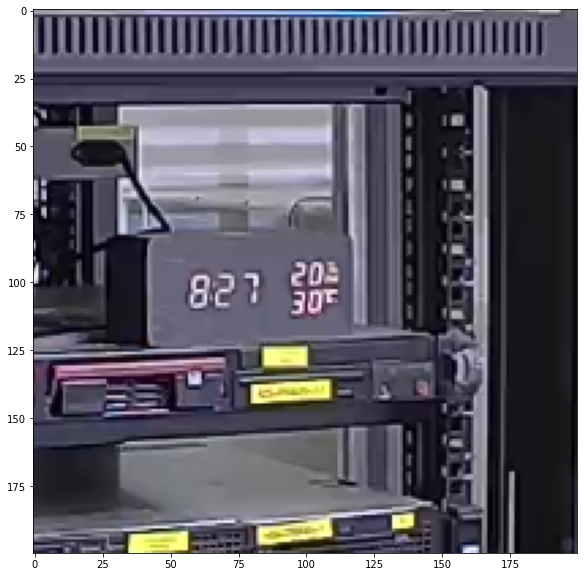

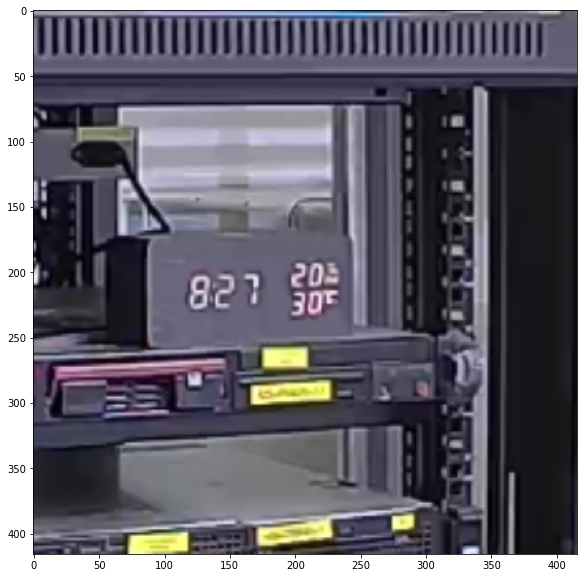

8:0.90 tf.Tensor([0.2789685  0.48619446 0.3212913  0.5553957 ], shape=(4,), dtype=float32)
0:0.87 tf.Tensor([0.49696574 0.44486254 0.53929985 0.5138468 ], shape=(4,), dtype=float32)
2:0.86 tf.Tensor([0.45839307 0.44906765 0.5025597  0.5118313 ], shape=(4,), dtype=float32)
3:0.84 tf.Tensor([0.46579134 0.50210005 0.504584   0.56412697], shape=(4,), dtype=float32)
2:0.80 tf.Tensor([0.3285342 0.4764898 0.3666798 0.5458567], shape=(4,), dtype=float32)
7:0.67 tf.Tensor([0.3725966  0.4728127  0.41572988 0.5432757 ], shape=(4,), dtype=float32)


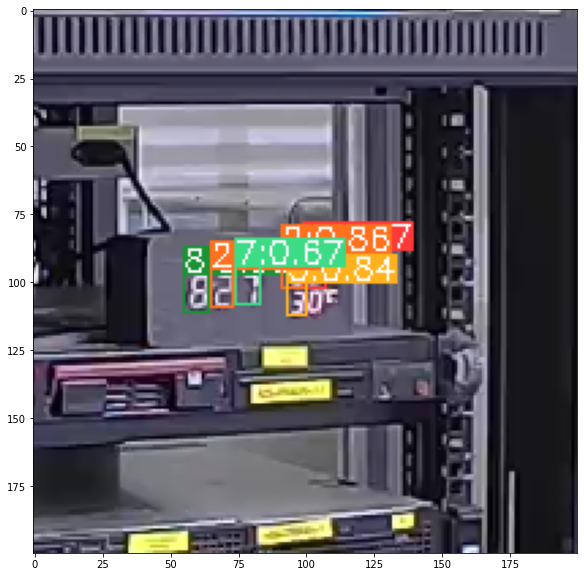

In [ ]:
image = cv2.imread("/content/2.50.07.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = image[50:250, 150:350, :]

plt.imshow(image)
plt.show()

# image_data = cv2.resize(image, (int(INPUT_SIZE/3), int(INPUT_SIZE/3)))
image_data = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE))

plt.imshow(image_data)
plt.show()

image_data = image_data / 255.

images_data = []
pred_bbox = []
for i in range(1):
    images_data.append(image_data)
images_data = np.asarray(images_data).astype(np.float32)
batch_data = tf.constant(images_data)
preds = infer_model(batch_data, training=False)

box_list = []
conf_list = []
for idx, output in enumerate(preds):
    if idx % 2 == 0 : continue
    boxes = output[:, :, :, :,  0:4]
    pred_conf = output[:, :, :, :, 4:]

    bs, xi, yi, anc, xywh = boxes.shape
    box_list.append(tf.reshape(boxes, (bs, -1, 1, xywh)))
    bs, xi, yi, anc, conf = pred_conf.shape
    conf_list.append(tf.reshape(pred_conf, (bs, -1, conf)))

boxes = tf.concat([box_list[0], box_list[1]], 1).numpy()
pred_conf =  tf.concat([conf_list[0], conf_list[1]], 1).numpy()

classes_prob =  pred_conf[:, :, 1:] * pred_conf[:, :, :1]

boxes[:,:,:,0] = boxes[:,:,:,0] - (boxes[:,:,:, 2] / 2) # x1
boxes[:,:,:,1] = boxes[:,:,:,1] - (boxes[:,:,:, 3] / 2) # y1

boxes[:,:,:,2] = boxes[:,:,:,0] + boxes[:,:,:, 2] # x2
boxes[:,:,:,3] = boxes[:,:,:,1] + boxes[:,:,:, 3] # y2

o_boxes, scores, classes, detections = tf.image.combined_non_max_suppression(
    boxes=boxes,
    scores=classes_prob,
    max_output_size_per_class= 20,
    max_total_size=30,
    iou_threshold=0.2,
    score_threshold=0.4,
    clip_boxes = False
)

o_h, o_w, _ = image.shape
for idx, box in enumerate(o_boxes[0][:detections[0]]):
    box = box / INPUT_SIZE
    x1 = int(o_w * box[0])
    y1 = int(o_h * box[1])
    x2 = int(o_w * box[2])
    y2 = int(o_h * box[3])

    class_idx = int(classes[0][idx])
    color = palette[class_idx]
    # score = int(scores[0][idx] * 100)

    cv2.rectangle(image, (x1, y1), (x2,y2), color, 1)
    cv2.rectangle(image, (x1, y1-10), (x1+40,y1), color, -1)
   
    cv2.putText(image, '{}:{:.2f}'.format(class_idx, scores[0][idx]), (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
    print('{}:{:.2f}'.format(class_idx, scores[0][idx]), box)


plt.rcParams["figure.figsize"] = (20,10)

plt.imshow(image)
plt.show()

In [ ]:
classes

<tf.Tensor: shape=(1, 30), dtype=float32, numpy=
array([[6., 3., 5., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
pred_conf.shape
# classes_prob.shape

(1, 2535, 11)

In [ ]:
image = cv2.imread("dataset/1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

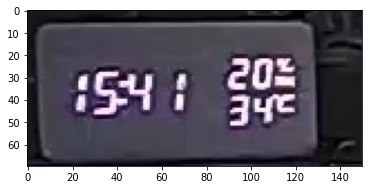

In [ ]:
plt.imshow(image[40:, 0:150])
plt.show()

In [ ]:
scores

<tf.Tensor: shape=(1, 30), dtype=float32, numpy=
array([[0.7175909, 0.5483335, 0.2934924, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ]],
      dtype=float32)>

In [ ]:
def inf(image_path, batch_data):
    # image = cv2.imread("dataset/digit_detector/eval/4.png")
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image_data = cv2.resize(image_data, (INPUT_SIZE, INPUT_SIZE))
    # image_data = image_data / 255.

    # images_data = []
    # pred_bbox = []
    # for i in range(1):
    #     images_data.append(image_data)
    # images_data = np.asarray(images_data).astype(np.float32)
    # batch_data = tf.constant(images_data)
    preds = infer_model(batch_data, training=False)

    box_list = []
    conf_list = []
    for idx, output in enumerate(preds):
        if idx % 2 == 0 : continue
        boxes = output[:, :, :, :,  0:4]
        pred_conf = output[:, :, :, :, 4:]

        bs, xi, yi, anc, xywh = boxes.shape
        box_list.append(tf.reshape(boxes, (bs, -1, 1, xywh)))
        bs, xi, yi, anc, conf = pred_conf.shape
        conf_list.append(tf.reshape(pred_conf, (bs, -1, conf)))

    boxes = tf.concat([box_list[0], box_list[1]], 1).numpy()
    pred_conf =  tf.concat([conf_list[0], conf_list[1]], 1).numpy()

    classes_prob =  pred_conf[:, :, 1:] * pred_conf[:, :, :1]

    boxes[:,:,:,0] = boxes[:,:,:,0] - (boxes[:,:,:, 2] / 2) # x1
    boxes[:,:,:,1] = boxes[:,:,:,1] - (boxes[:,:,:, 3] / 2) # y1

    boxes[:,:,:,2] = boxes[:,:,:,0] + boxes[:,:,:, 2] # x2
    boxes[:,:,:,3] = boxes[:,:,:,1] + boxes[:,:,:, 3] # y2

    o_boxes, scores, classes, detections = tf.image.combined_non_max_suppression(
        boxes=boxes,
        scores=classes_prob,
        max_output_size_per_class= 20,
        max_total_size=30,
        iou_threshold=0.4,
        score_threshold=0.1,
        clip_boxes = False
    )

    # path = testset.annotations[idx, 0]
    image = cv2.imread(image_path)
    plt.imshow(image)
    plt.show()
    o_h, o_w, _ = image.shape
    for idx, box in enumerate(o_boxes[0][:detections[0]]):
        box = box / INPUT_SIZE
        x1 = int(o_w * box[0])
        y1 = int(o_h * box[1])
        x2 = int(o_w * box[2])
        y2 = int(o_h * box[3])

        class_idx = int(classes[0][idx])
        color = palette[class_idx]
        # score = int(scores[0][idx] * 100)

        cv2.rectangle(image, (x1, y1), (x2,y2), color, 1)
        cv2.rectangle(image, (x1, y1-10), (x1+40,y1), color, -1)
    
        cv2.putText(image, '{}:{:.2f}'.format(class_idx, scores[0][idx]), (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
        print('{}:{:.2f}'.format(class_idx, scores[0][idx]), box)
        
    plt.imshow(image)
    plt.show()


In [ ]:
#model.load_weights( './didimdol/checkpoints/yolov4') # "./didimdol/checkpoints/yolov4")
infer_model = tf.keras.models.load_model('./didimdol/checkpoints/yolov4/400', compile = False)
# model = infer_model

In [ ]:
import model.tensorflow.yolo.utils as utils


In [ ]:
annot_path = 'dataset/digit_detector/test_digit.txt'
testset = Dataset(annot_path, INPUT_SIZE, 1,  CLASSES, ANCHORS, ANCHOR_PER_SCALE, STRIDES, data_aug=False, is_training=False)
len(testset)

13068

0it [00:00, ?it/s]

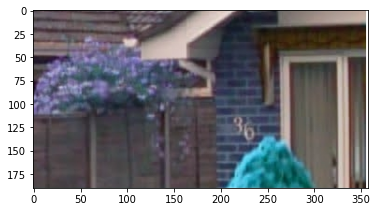

2:0.98 tf.Tensor([0.38760507 0.38084808 0.49097922 0.59226507], shape=(4,), dtype=float32)
2:0.57 tf.Tensor([0.50128925 0.38567212 0.600486   0.59890604], shape=(4,), dtype=float32)
7:0.25 tf.Tensor([0.49019724 0.34678608 0.60331446 0.5749769 ], shape=(4,), dtype=float32)
3:0.10 tf.Tensor([0.50128925 0.38567212 0.600486   0.59890604], shape=(4,), dtype=float32)


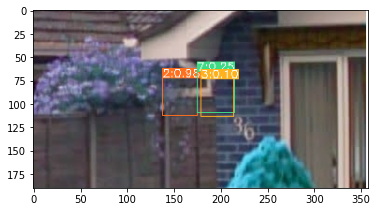

0it [00:00, ?it/s]


In [ ]:
for idx, (images, target) in tqdm(enumerate(testset)):
    image_path = testset.annotations[0].split()[0]
    inf(image_path, images)
    break

In [ ]:
testset.annotations[0].split()[0]

'dataset/digit_detector/train/5946.png'

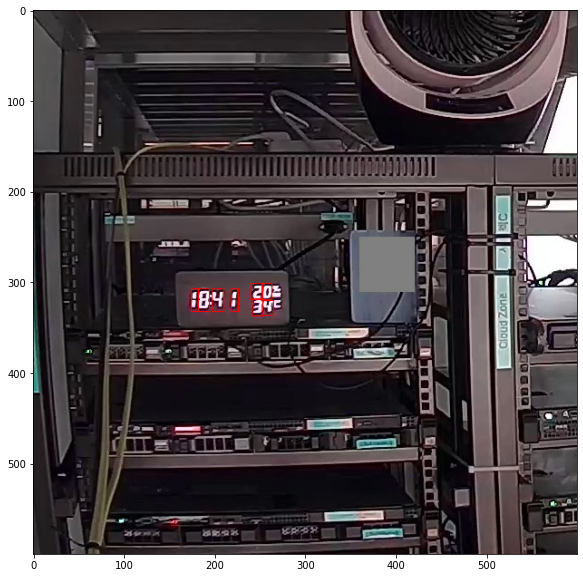

In [ ]:
# annot_path = 'dataset/server_room_aug/train_digit_daylight.txt'

# with open(annot_path, 'r') as f:
# row = f.readline()
# col = row.split()
img = cv2.imread('/home/dataset/server_room_aug/train_zoom_left_clock/1842_image_4_0_0.jpg')

# rect = col[1]

col = '252,301,263,319,0 174,307,182,332,1 218,307,226,332,1 240,301,253,319,2 241,318,253,337,3 197,307,210,332,4 253,320,265,336,4 182,307,194,332,8'.split()

for rect in col:
    rect = rect.split(',')
    rect = np.array(rect, dtype=np.int16)

    cv2.rectangle(img, (rect[0], rect[1]), (rect[2],rect[3]), (255,0,0), 1)

plt.imshow(img)
plt.show()
    

array(['72', '274', '87', '299', '0'], dtype='<U3')